Check adding recurrent all-to-all inhibition actually does:

1. Reduces the FOIL response more than it reduces the FAN, but still isn't an effective way to get the response desired
2. Not need spacing between presentations to get accurate MEG signal

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes, numpy_bytes_to_str, norm_spa_vecs
from nengo_learn_assoc_mem.learning_rules.neg_voja import NegVoja
from nengo_learn_assoc_mem.learning_rules import rec_bcm

from collections import namedtuple

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Setup vocab

In [2]:
with h5py.File("data/neg_voja_enc.h5", "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']
    
    fin_enc = np.array(fi['encoders'])
    n_neurons = fin_enc.shape[0]
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons
    seed = fi['encoders'].attrs['seed']
    

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 't_range', 'vocab_strings', 'vocab_vectors']


In [3]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [4]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [5]:
def meg_from_sim(inhib: float, t_pres: float, t_paus: float):
    feed = BasicVecFeed(feed_vecs, feed_vecs, t_pres, dimensions, len(feed_vecs), t_paus)

    rec_inhib = inhib*(np.ones(n_neurons) - np.eye(n_neurons))

    with nengo.Network() as model:
        in_nd = nengo.Node(feed.feed)

        ens = nengo.Ensemble(n_neurons, dimensions,
                             encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

        nengo.Connection(in_nd, ens)
        nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib, synapse=0.01)

        p_in = nengo.Probe(in_nd)
        p_spikes = nengo.Probe(ens.neurons)

    with nengo.Simulator(model) as sim:
        sim.run(len(feed_vecs)*t_each + t_pause)
    
    return sim.trange(), meg_from_spikes(sim.data[p_spikes])

## Setup and run short

In [56]:
t_pause = 0.1
td_pause = int(t_pause / dt) 
t_present = 0.3
t_each = t_pause + t_present
td_each = int(t_each / dt)

In [57]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [58]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [55]:
base_inhib = -2e-3

In [10]:
base_trange, base_meg = meg_from_sim(base_inhib, t_present, t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:15.                                                 


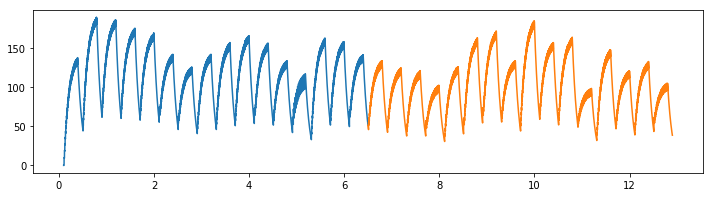

In [11]:
plt.figure(figsize=(12, 3))
plt.plot(base_trange[fan1_slc], base_meg[fan1_slc])
plt.plot(base_trange[fan2_slc], base_meg[fan2_slc])

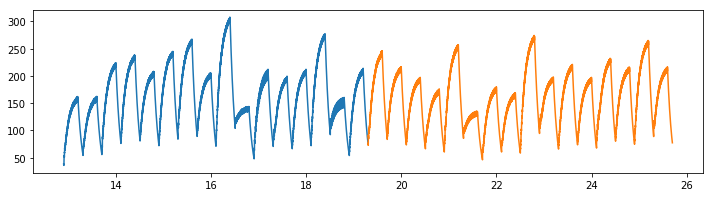

In [12]:
plt.figure(figsize=(12, 3))
plt.plot(base_trange[foil1_slc], base_meg[foil1_slc])
plt.plot(base_trange[foil2_slc], base_meg[foil2_slc])

In [13]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = base_meg[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

base_act_df = pd.concat(df_list)

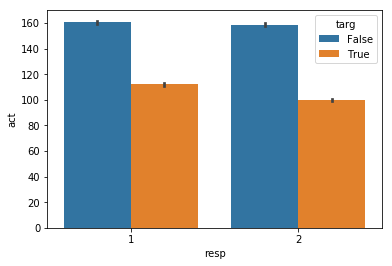

In [14]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=base_act_df)

## Setup and run long

In [42]:
t_pause = 0.4
td_pause = int(t_pause / dt) 
t_present = 0.3
t_each = t_pause + t_present
td_each = int(t_each / dt)

In [43]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [44]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [45]:
base_inhib = -2e-3

In [46]:
long_trange, long_meg = meg_from_sim(base_inhib, t_present, t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:25.                                                 


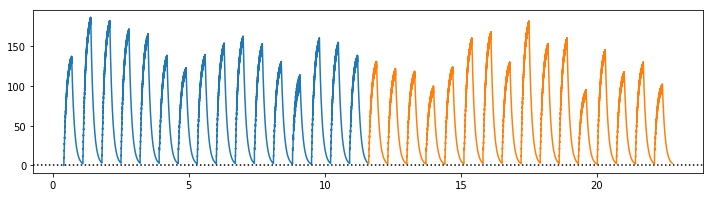

In [51]:
plt.figure(figsize=(12, 3))
plt.plot(long_trange[fan1_slc], long_meg[fan1_slc])
plt.plot(long_trange[fan2_slc], long_meg[fan2_slc])
plt.axhline(0, color='k', linestyle=':')

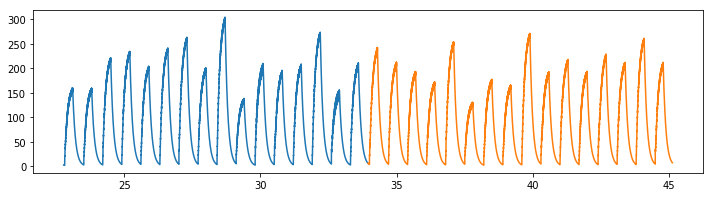

In [48]:
plt.figure(figsize=(12, 3))
plt.plot(long_trange[foil1_slc], long_meg[foil1_slc])
plt.plot(long_trange[foil2_slc], long_meg[foil2_slc])

In [40]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = long_meg[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

long_act_df = pd.concat(df_list)

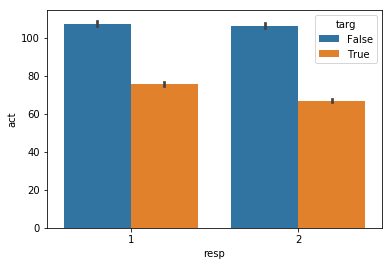

In [41]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=long_act_df)

# Setup and run increased inhib

In [56]:
t_pause = 0.1
td_pause = int(t_pause / dt) 
t_present = 0.3
t_each = t_pause + t_present
td_each = int(t_each / dt)

In [57]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [58]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [98]:
more_inhib = base_inhib * 1e10
more_inhib

-20000000.0

In [99]:
inhib_trange, inhib_meg = meg_from_sim(more_inhib, t_present, t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:16.                                                 


In [100]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = base_meg[obj.slc] - inhib_meg[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

diff_df = pd.concat(df_list)

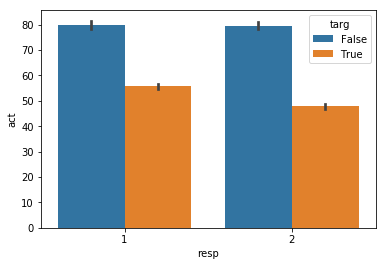

In [101]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=diff_df)

In [102]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = inhib_meg[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

inhib_act_df = pd.concat(df_list)

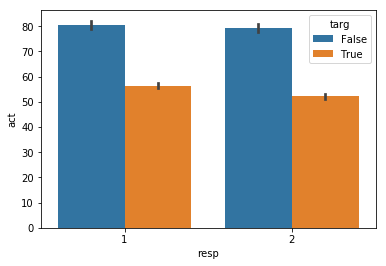

In [103]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=inhib_act_df)